<a href="https://colab.research.google.com/github/tianyueniu/mouse_movement_personality/blob/master/Mouse_Movement_%26_Personality%20Codebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Personality Data Preprocessing
Step 1: Read personality data from recorded files. Removed unecessary columns; extract gender & age.  
Step 2: Removed problematic rows (e.g. dropped a few missing values, dropped a few incorrect entries).   
Step 3: Normalized big 5 personality scores, checked personality score distribution for each trait.    
Step 4: Checked personality score distribution by age and gender.


*For privacy reasons, Step 1, 2, 3 are not shown here. True worker IDs and related information were replaced with pseudo ids after step 3. Date of study was also changed to '2020-01-01' for all participants. The result csv file is read here to perform further analysis.*

Now let's jump to step 4 to check personality score distribution.



In [71]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statistics
import scipy
import statsmodels.api as sm
from scipy import stats
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#read in cleaned file from github
df = pd.read_csv('https://raw.githubusercontent.com/tianyueniu/mouse_movement_personality/master/study12pilots_personality_id_cleaned.csv')

In [3]:
df.head(5)

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,BirthYear,Gender,Study,Age,pseudo_workerID
0,37,39,35,8,33,1987,Male,pilot1_1,33,P1242886303
1,34,39,35,11,31,1960,Male,pilot1_1,60,P5659489757
2,30,37,32,10,27,1968,Female,pilot1_1,52,P4588440356
3,8,33,35,15,11,1977,Female,pilot1_1,43,P6618403320
4,19,27,27,22,18,1988,Female,pilot1_1,32,P3602510382


In [4]:
df.Study.value_counts()

study01     123
study02     121
pilot2_2     61
pilot1_1     61
pilot1_5     61
pilot1_6     60
pilot1_8     59
pilot1_2     59
pilot1_4     58
pilot1_3     57
pilot1_7     56
pilot2_1     55
Name: Study, dtype: int64

There are multiple studies here. Each asks the participants to rate the street images they see based on a different criteria (e.g. transparency, complexity, etc). Below is a dictionary matching each study with its criterion:

In [5]:
description = {"study01":"like", 
               "study02":"dislike", 
               "pilot1_1":"preference", 
               "pilot1_2":"walkability", 
               "pilot1_3":"imageability",
               "pilot1_4":'complexity',
               "pilot1_5":'enclosure',
               "pilot1_6":'humanscale1', 
               "pilot1_7":"transparency", 
               "pilot1_8":"order1", 
               "pilot2_1":"humanscale2", 
               'pilot2_2':'order2'}

Each study has a separate folder of participant's mouse tracking json files.

In [6]:
#normalize personality scores
df['Extraversion_N'] = df['Extraversion'].astype(float)/8
df['Agreeableness_N'] = df['Agreeableness'].astype(float)/9
df['Conscientiousness_N'] = df['Conscientiousness'].astype(float)/9
df['Neuroticism_N'] = df['Neuroticism'].astype(float)/8
df['Openness_N'] = df['Openness'].astype(float)/10

In [7]:
#check mean personality score
df.mean().tail(5)

Extraversion_N         2.832130
Agreeableness_N        3.754513
Conscientiousness_N    3.905335
Neuroticism_N          2.527076
Openness_N             3.608424
dtype: float64

In [8]:
#check var personality score
df.var().tail(5)

Extraversion_N         0.930709
Agreeableness_N        0.542132
Conscientiousness_N    0.594419
Neuroticism_N          0.920840
Openness_N             0.596122
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

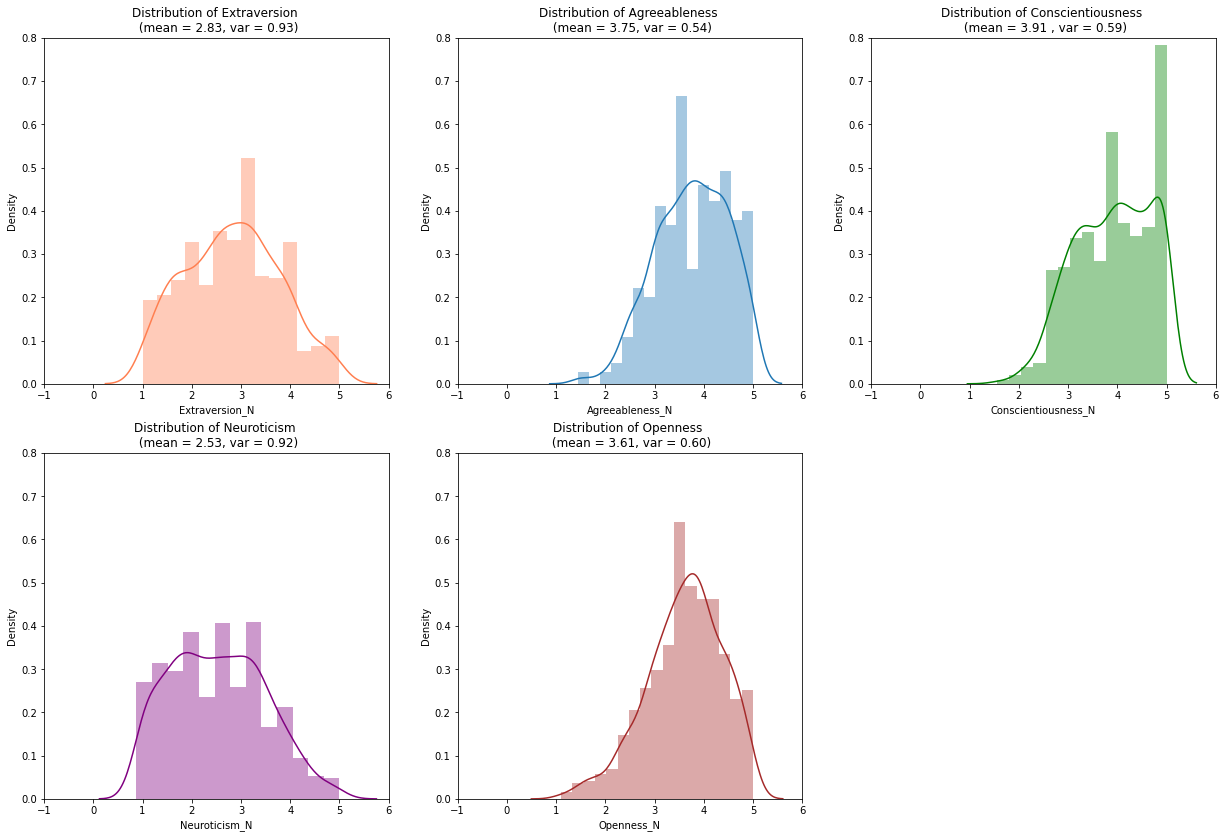

In [9]:
#plot normalized personality scores
plt.figure(figsize=(21,14))
plt.subplot(2,3,1)
sb.distplot(df['Extraversion_N'], color='coral')
plt.xlim(-1, 6)
plt.ylim(0,0.8)
plt.title('Distribution of Extraversion \n (mean = 2.83, var = 0.93)')
plt.subplot(2,3,2)
sb.distplot(df['Agreeableness_N'])
plt.xlim(-1, 6)
plt.ylim(0,0.8)
plt.title('Distribution of Agreeableness \n (mean = 3.75, var = 0.54)')
plt.subplot(2,3,3)
sb.distplot(df['Conscientiousness_N'], color='green')
plt.xlim(-1, 6)
plt.ylim(0,0.8)
plt.title('Distribution of Conscientiousness \n (mean = 3.91 , var = 0.59)')
plt.subplot(2,3,4)
sb.distplot(df['Neuroticism_N'], color='purple')
plt.xlim(-1, 6)
plt.ylim(0,0.8)
plt.title('Distribution of Neuroticism \n (mean = 2.53, var = 0.92)')
plt.subplot(2,3,5)
sb.distplot(df['Openness_N'], color='brown')
plt.xlim(-1, 6)
plt.ylim(0,0.8)
plt.title('Distribution of Openness \n (mean = 3.61, var = 0.60)');

Conscientiousness, Openness and Agreeableness are right skewed. Neuroticism is slighly left skewed, and extraversion is approximately evenly distributed. These distributions are validated by  the general population distribution shown in other literatures.

*John, O. P., & Srivastava, S. (1999). The Big-Five trait taxonomy: History, measurement, and theoretical perspectives. In L. A. Pervin & O. P. John (Eds.), Handbook of personality: Theory and research (Vol. 2, pp. 102–138). New York: Guilford Press.*




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

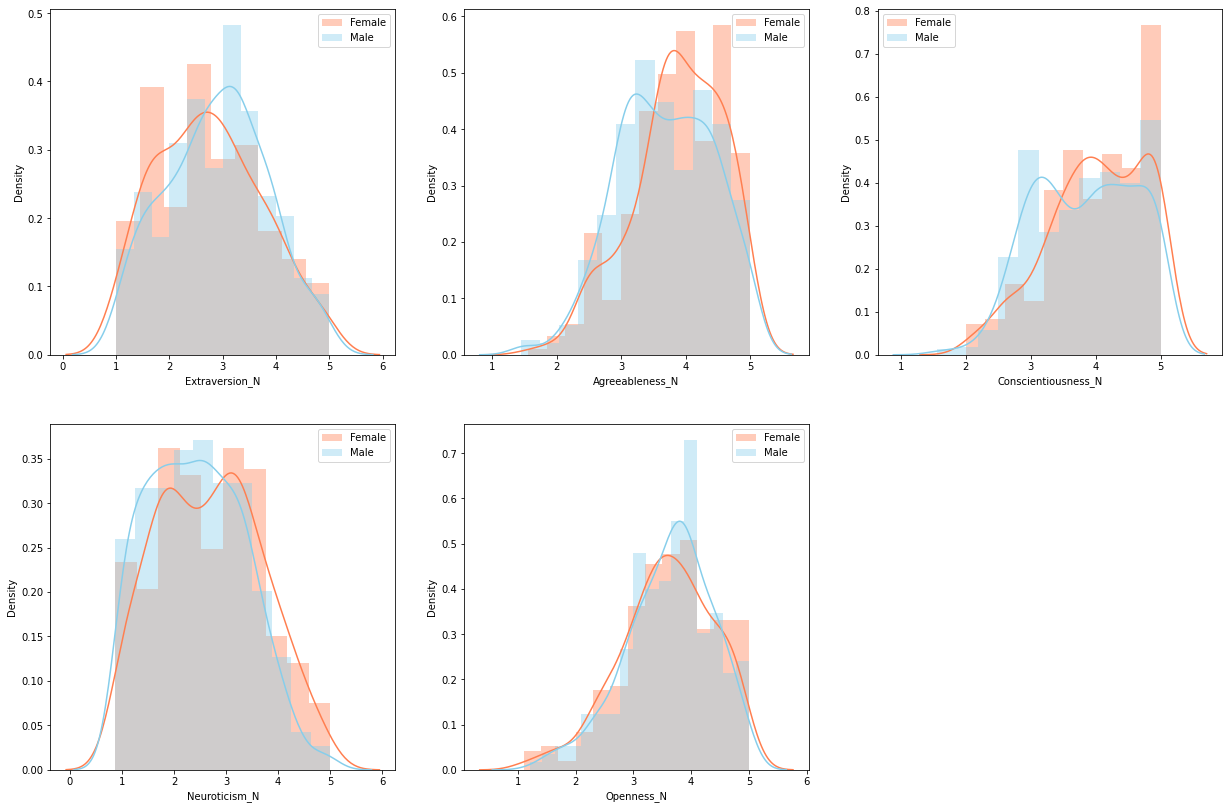

In [10]:
#examine personality distribution by gender
male = df[df.Gender=="Male"]
female = df[df.Gender=="Female"]
other = df[df.Gender=="Other"]

#plot normalized personality scores
plt.figure(figsize=(21,14))
plt.subplot(2,3,1)
sb.distplot(female['Extraversion_N'], color='coral', label='Female')
sb.distplot(male['Extraversion_N'], color='skyblue', label='Male')
plt.legend()
plt.subplot(2,3,2)
sb.distplot(female['Agreeableness_N'], color='coral', label='Female')
sb.distplot(male['Agreeableness_N'], color='skyblue', label='Male')
plt.legend()
plt.subplot(2,3,3)
sb.distplot(female['Conscientiousness_N'], color='coral', label='Female')
sb.distplot(male['Conscientiousness_N'], color='skyblue', label='Male')
plt.legend()
plt.subplot(2,3,4)
sb.distplot(female['Neuroticism_N'], color='coral', label='Female')
sb.distplot(male['Neuroticism_N'], color='skyblue', label='Male')
plt.legend()
plt.subplot(2,3,5)
sb.distplot(female['Openness_N'], color='coral', label='Female')
sb.distplot(male['Openness_N'], color='skyblue', label='Male')
plt.legend();

Extraversion: male mean higher   
Agreeableness: female mean higher  
Conscientiousness: female mean higher  
Neuroticism: female mean slightly higher
Openness: similar

These distributions are again supported by literature.

*Costa, P. T., Terracciano, A., & Mccrae, R. R. (2001). Gender differences in personality traits across cultures: Robust and surprising findings. Journal of Personality and Social Psychology, 81(2), 322–331. doi: 10.1037/0022-3514.81.2.322*

## Linking Mouse Tracking Data with Personality Data

This part of the notebook links each participant's mouse tracking files with their demographic data and process the mouse tracking files (jsons).

As described in the previous section, multiple studies are included in the analysis. In each different study, participants are asked to choose four images based on a different criterion (e.g. imageability, walkability, enclosure, etc). Each study has a separate folder of participants mouse tracking files. Each participant's mouse tracking data is recorded in a json file.

In [11]:
#now let's create a separate dataframe for study1
study1 = df[df['Study']=='study01'].copy().reset_index(drop=True)

In [12]:
study1.head(3)

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,BirthYear,Gender,Study,Age,pseudo_workerID,Extraversion_N,Agreeableness_N,Conscientiousness_N,Neuroticism_N,Openness_N
0,20,33,40,34,48,1975,Female,study01,45,P4499305916,2.500,3.666667,4.444444,4.250,4.8
1,31,44,43,10,43,1991,Male,study01,29,P4155053201,3.875,4.888889,4.777778,1.250,4.3
2,13,31,21,35,37,1962,Male,study01,58,P5225207817,1.625,3.444444,2.333333,4.375,3.7


In [13]:
keys_study1 = list(study1['pseudo_workerID'])

To walk through the process, json files for the above three participants have been manually processed and uploaded to github here: https://github.com/tianyueniu/mouse_movement_personality/tree/master/sample_mouse_data.   

In [14]:
def plot_one_participant(jsonfile):

    #loop through the json to see which ones are true trials, which ones are not true trials
    #create a dictionary containing two lists of attention trial indices and normal trials indices
    trial_index = {"attention":[], 'normal':[]}
    for i in range(len(jsonfile)):
        if jsonfile[i].get('image_array') is not None:
            if len(jsonfile[i]['attention_check'])!=0:
                trial_index['attention'].append(i)
            else:
                trial_index['normal'].append(i)

    #define a function to loop through a list of indices given and plot mouse movement patterns
    def plot_movements(indices, text):
        count = 0
        for i in indices:
            count +=1
            mouse = pd.DataFrame(jsonfile[i]['mouse_track'], columns=['timestamp', 'x', 'y', 'click'])
            fig = plt.figure(figsize=(18,5))
            plt.subplot(1,3,1)
            sb.scatterplot(x='x',y='y', data=mouse, hue='click', style='click',
                           x_jitter=0.2, y_jitter=0.2, legend=False,
                           palette=['orange','blue'], size = mouse['click']*150)
            plt.title('Overall Mouse Movement')
            plt.subplot(1,3,2)
            sb.lineplot(x='timestamp',y='x', data=mouse)
            plt.title('Movement on X-axis');
            plt.subplot(1,3,3)
            sb.lineplot(x='timestamp',y='y', data=mouse)
            plt.title('Movement on Y-axis')
            fig.suptitle(text.format(count))

    #check first five attention trials mouse movement
    plot_movements(trial_index['attention'][:5], 'ATTENTION TRIAL (head) {}')
    #check last five attention trials mouse movement
    plot_movements(trial_index['attention'][-5:], 'ATTENTION TRIAL (tail) {}')
    #check first five normal trials mouse movement
    plot_movements(trial_index['normal'][:5], 'NORMAL TRIAL (head) {}')
    #check last five normal trials mouse movement
    plot_movements(trial_index['normal'][-5:], 'NORMAL TRIAL (tail) {}')
    
    return

In [15]:
#get json file from github
#NOTE: only keys_study[0], keys_study[1] and keys_study[2] can be found in github
#these data are manually processed; private information is removed from these data
url = 'https://raw.githubusercontent.com/tianyueniu/mouse_movement_personality/master/sample_mouse_data/{}.json'.format(keys_study1[0])
resp = requests.get(url)
data = json.loads(resp.text)

In [16]:
data[1] #sbj_id and task_id are removed for privacy reasons

{'exp_stage': 'fire_instructions_page',
 'internal_node_id': '0.0-1.0',
 'rt': 56296,
 'sbj_id': '',
 'task_id': '',
 'time_elapsed': 65167,
 'trial_index': 1,
 'trial_type': 'instructions',
 'view_history': '[{"page_index":0,"viewing_time":15939},{"page_index":1,"viewing_time":11181},{"page_index":2,"viewing_time":5400},{"page_index":3,"viewing_time":5540},{"page_index":4,"viewing_time":3688},{"page_index":5,"viewing_time":5578},{"page_index":6,"viewing_time":3899},{"page_index":7,"viewing_time":2686},{"page_index":8,"viewing_time":2384}]'}

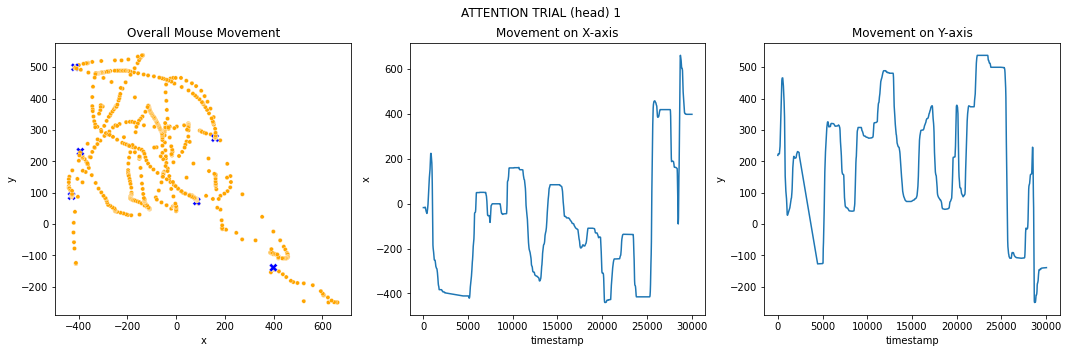

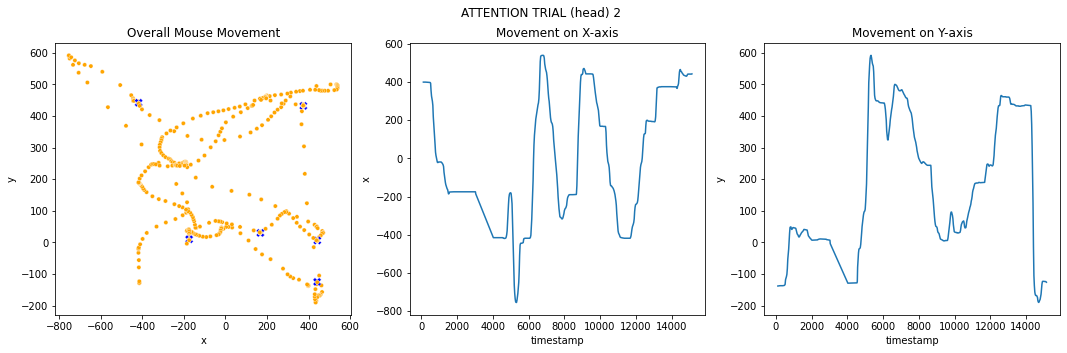

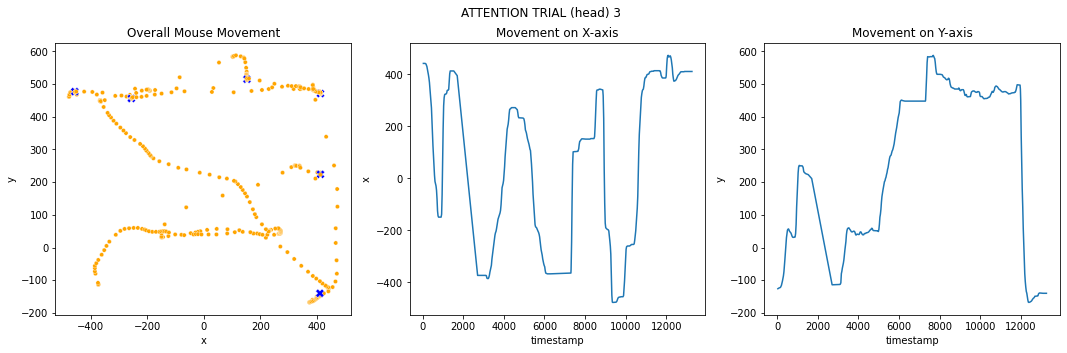

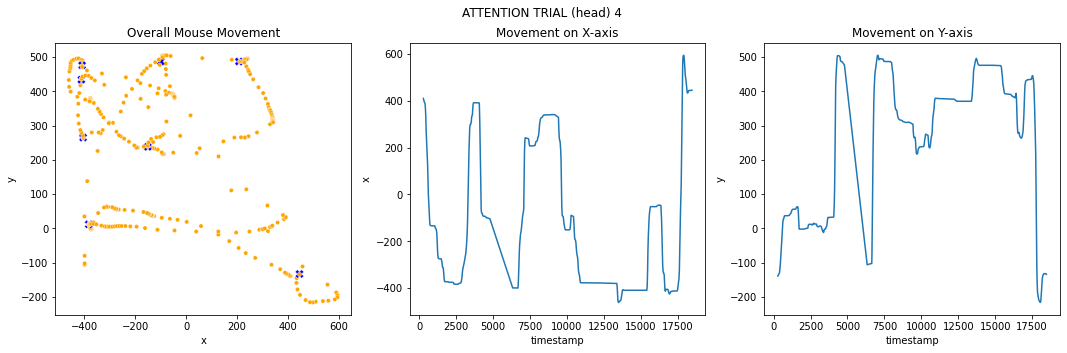

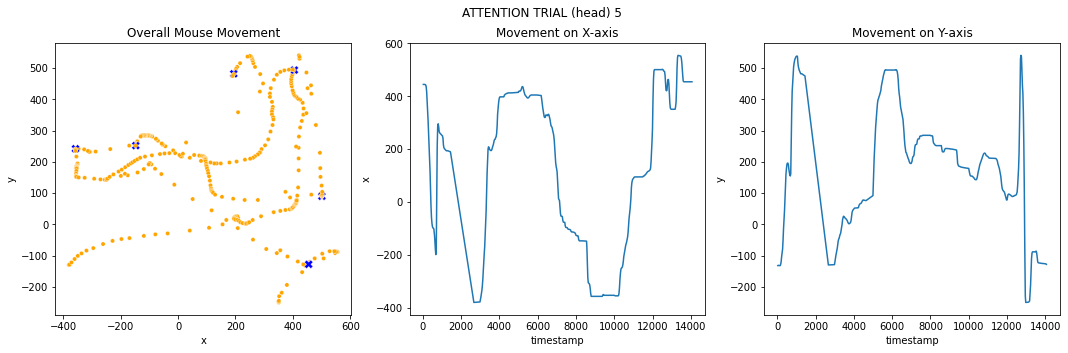

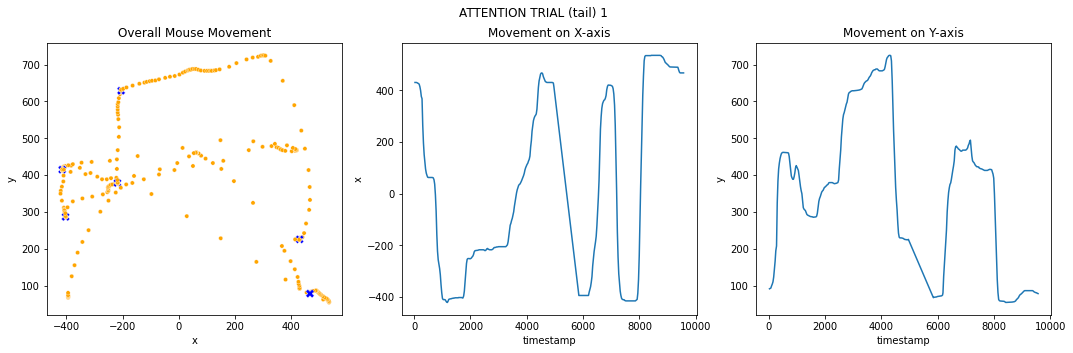

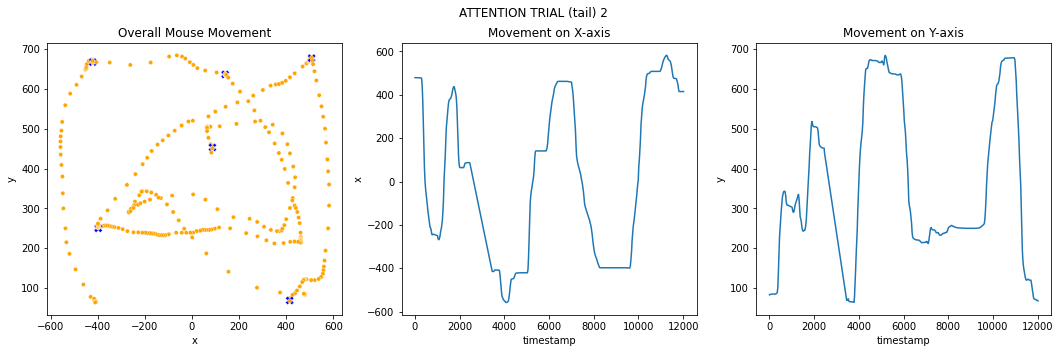

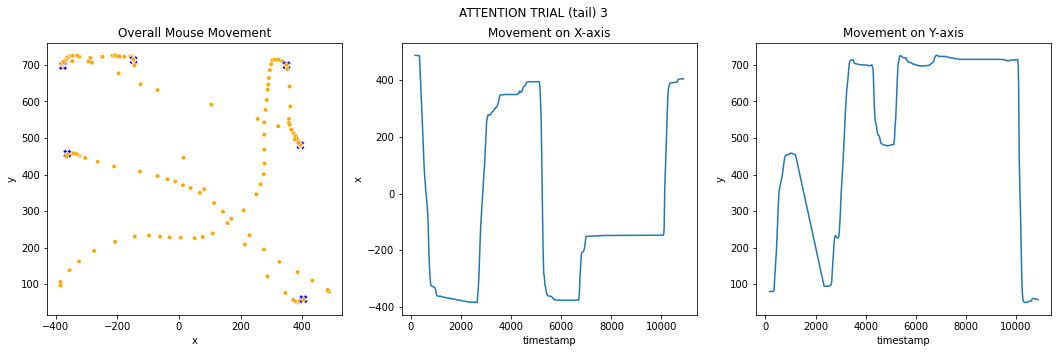

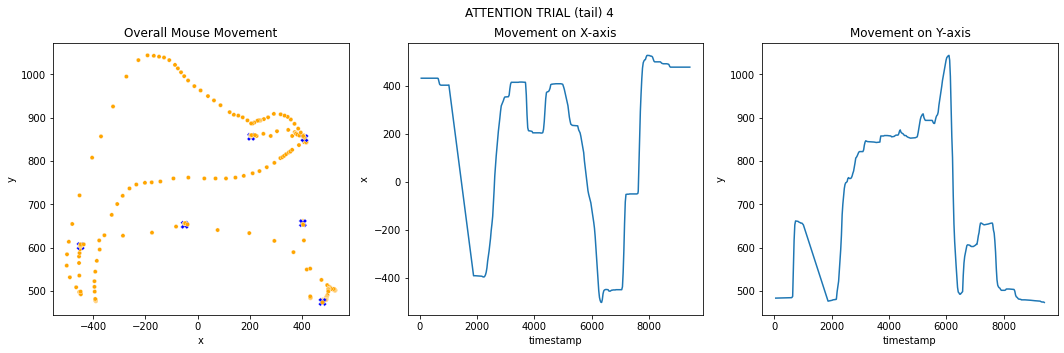

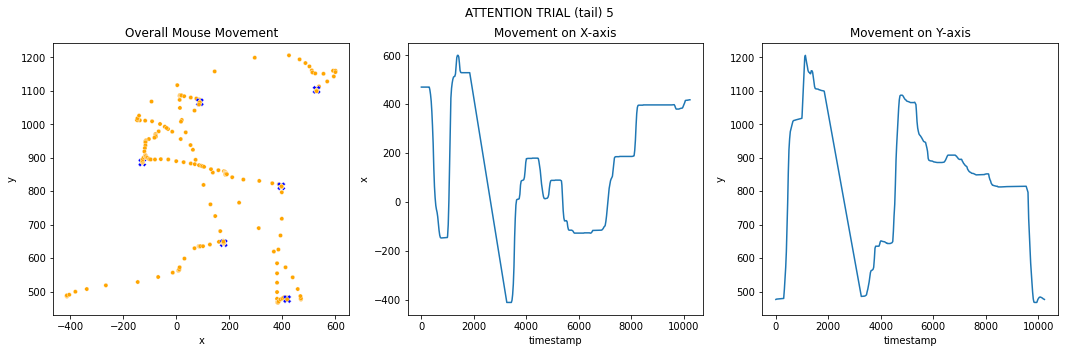

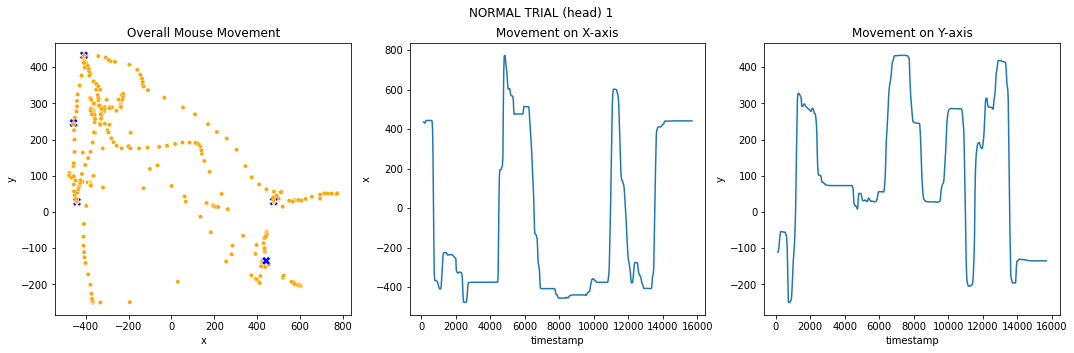

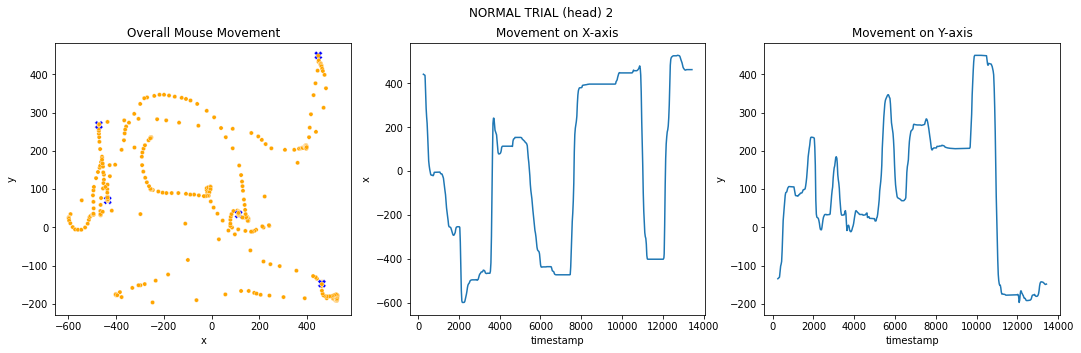

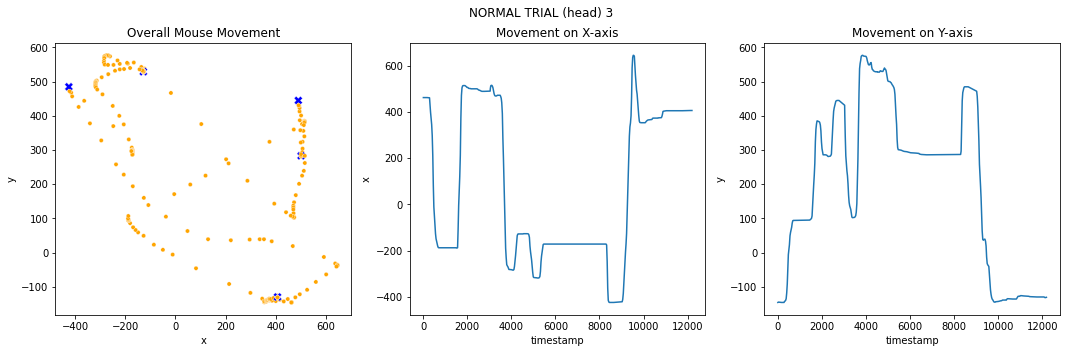

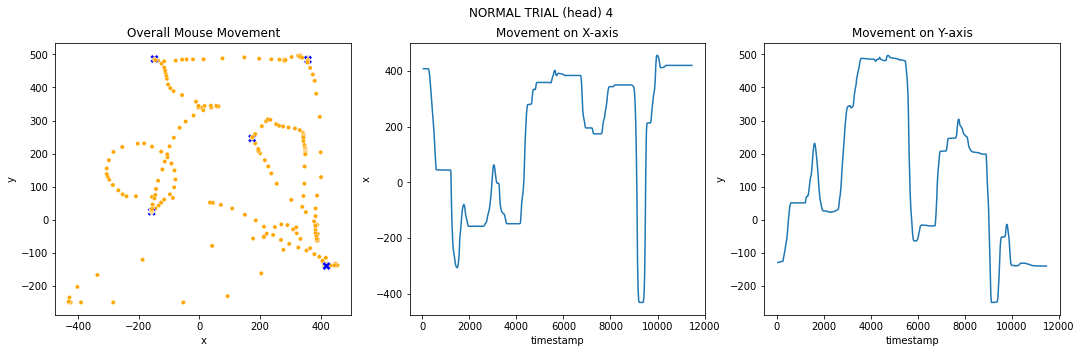

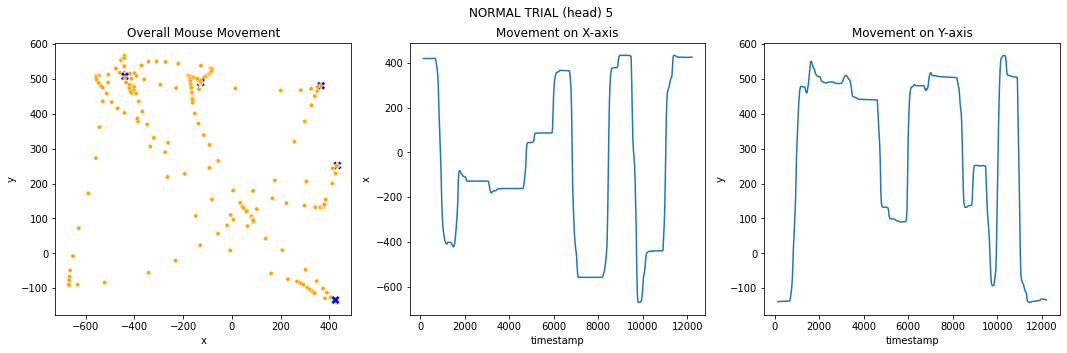

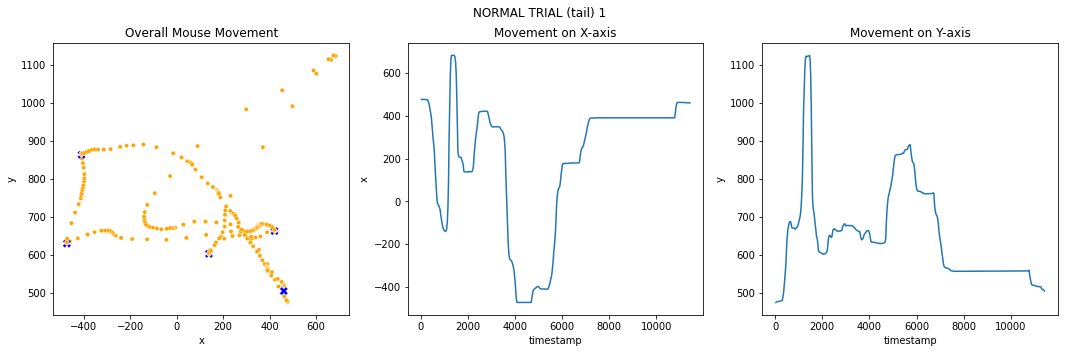

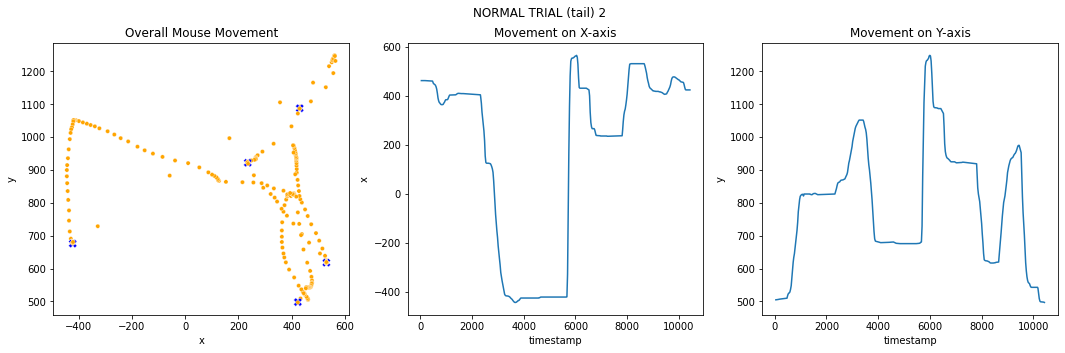

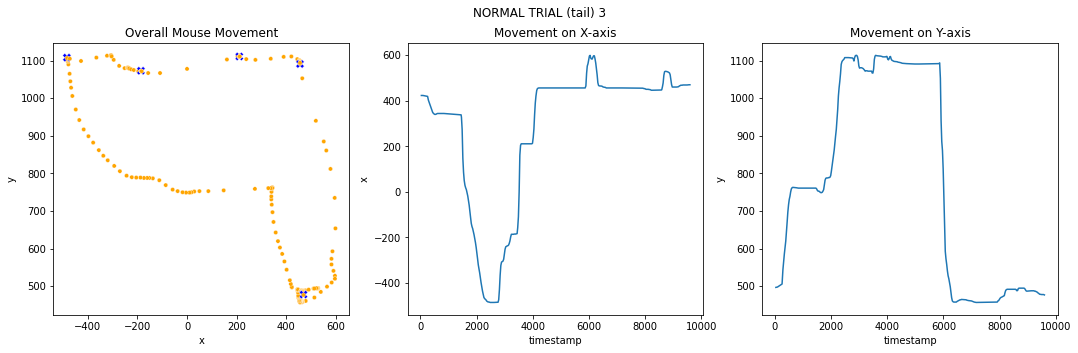

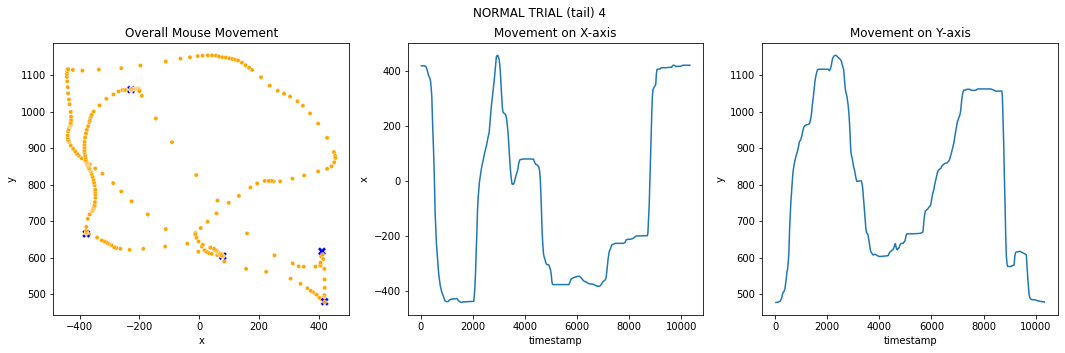

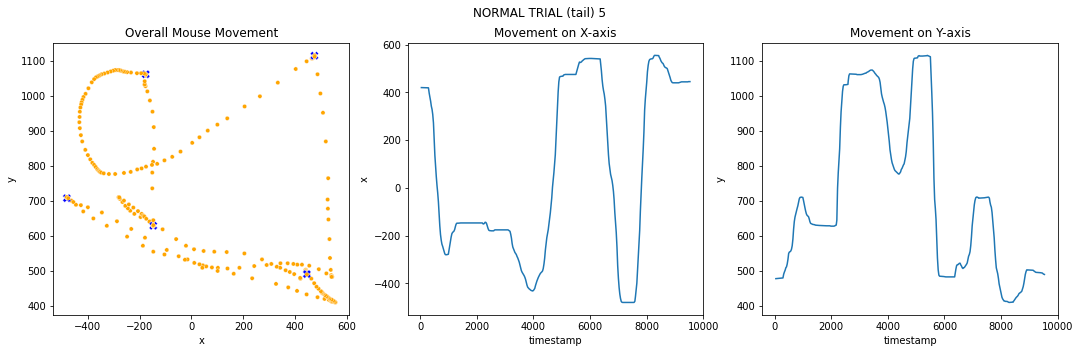

In [17]:
#plot that participant's mouse movement patterns
plot_one_participant(data)

## Extract Mouse Movement Features
This part of the notebook defines functions to extract click and other movement patterns from participants' mouse tracking data.

1) Extract movement, clicks and pauses  
2) Extract fixations  
3) Merge in data on inattentiveness  

We will again be using the three sample data from study1 to walk through the process.



In [18]:
#create our mini df including only the three sample data
study1_sample_df = study1[:3].copy().reset_index(drop=True)

In [19]:
study1_sample_df

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,BirthYear,Gender,Study,Age,pseudo_workerID,Extraversion_N,Agreeableness_N,Conscientiousness_N,Neuroticism_N,Openness_N
0,20,33,40,34,48,1975,Female,study01,45,P4499305916,2.500,3.666667,4.444444,4.250,4.8
1,31,44,43,10,43,1991,Male,study01,29,P4155053201,3.875,4.888889,4.777778,1.250,4.3
2,13,31,21,35,37,1962,Male,study01,58,P5225207817,1.625,3.444444,2.333333,4.375,3.7


In [20]:
study1_sample_keys = keys_study1[:3]
study1_sample_keys #these are pseudo keys

['P4499305916', 'P4155053201', 'P5225207817']

1) Extract movement, clicks and pauses

In [21]:
#find number of clicks

def find_clicks(keys): 
    #this function return average clicks per trial & proportion of trials in 
    #which participants performed extra clicks than necessary 
    #in both attention and normal trials

    clicks_final = []
    
    for i in range(len(keys)):
    #for each participant in the data
        url = 'https://raw.githubusercontent.com/tianyueniu/mouse_movement_personality/master/sample_mouse_data/{}.json'.format(keys[i])
        resp = requests.get(url)
        test = json.loads(resp.text)

        res = {"attention_click":[], 'attention_trial_count':0, 'attention_reclick':0, 
               'normal_click':[], 'normal_trial_count':0, 'normal_reclick':0}
        
        for i in range(len(test)):
        #for each trial completed by the participant
            
            if test[i].get('image_array') is not None:
            #if this is a mouse tracking trial
                if len(test[i]['attention_check'])!=0:
                #if this is an attention trial
                    res['attention_trial_count']+=1 #count number of attention trials
                    clicks = np.sum(test[i]['mouse_track'], axis=0)[3] #count num clicks
                    if clicks > 6: 
                        res['attention_reclick']+=1 #count reclick
                    res['attention_click'].append(clicks) 
                else:
                #if this is a normal trial
                    res['normal_trial_count']+=1
                    clicks = np.sum(test[i]['mouse_track'], axis=0)[3]
                    if clicks > 5:
                        res['normal_reclick']+=1
                    res['normal_click'].append(clicks) 
                    
        avg_click_attention = sum(res['attention_click'])/len(res['attention_click']) #avg click per trial
        reclick_percent_att = res['attention_reclick']/res['attention_trial_count'] # proportion of trials with reclick
        avg_click_normal = sum(res['normal_click'])/len(res['normal_click'])
        reclick_percent_normal = res['normal_reclick']/res['normal_trial_count']
        
        clicks_final.append([avg_click_attention,reclick_percent_att, 
                             avg_click_normal, reclick_percent_normal])
    
    return clicks_final     

We are measuring reclicks because some participants make changes to their selections in the same trial. This would result in more clicks than necessary per trial and might be reflective of their personalities.

To elaborate, in order for participants to complete the task, they would have to click 5 times in normal trials (4 selection clicks and 1 click on the ‘next’ button), and 6 times in attention check trials (4 selection clicks, 1 drag click, and 1 click on the ‘next’ button). The percent of trials in which a participant made more clicks than necessary was therefore calculated to quantify 'reconsideration' or 'impatience'. The percents of reconsideration were calculated separately for attention trials and normal trials because the majority of the attention trials are located at the beginning of the task, and so participants might be clicking more in attention trials for exploration, whereas clicking more in normal trials are more reflective of 'reconsideration' or 'impatience'.

In [22]:
#extract movement features such as distance and speed

def find_movement(keys):   

    #this function returns return average x distance travelled (guiding pattern), 
    #average euclidean distance travelled, average speed, 
    #and average completion time across trials

    final = []
    
    for k in range(len(keys)):
    #for each participant in the data
        url = 'https://raw.githubusercontent.com/tianyueniu/mouse_movement_personality/master/sample_mouse_data/{}.json'.format(keys[k])
        resp = requests.get(url)
        test = json.loads(resp.text)

        distance_x_total = [] #a list of distance x moved per trial
        speed_total = [] #a list of euclidean speed per trial
        euclidean_total = [] # a list of euclidean distance moved per trial
        time_total = [] #a list of trial completion time
        
        for i in range(len(test)):
        #for each trial
            if test[i].get('image_array') is not None:
            #if this is a valid mouse tracking trial
                prev_x = None
                prev_y = None
                distance_x = 0
                euclidean = 0
                for move in test[i]['mouse_track']:
                    if prev_x!= None:
                        distance_x += abs(move[1]-prev_x)
                        euclidean += abs(((move[1]-prev_x)**2+(move[2]-prev_y)**2)**(1/2))
                        prev_x = move[1]
                        prev_y = move[2]
                    else:
                        prev_x = move[1]
                        prev_y = move[2]
                time = test[i]['mouse_track'][-1][0] - test[i]['mouse_track'][0][0]
                distance_x_total.append(distance_x)
                euclidean_total.append(euclidean)
                speed_total.append(euclidean/time)
                time_total.append(time)
                
        final.append([sum(distance_x_total)/len(distance_x_total), #avg x distance per trial
                     sum(euclidean_total)/len(euclidean_total), #avg euclidean distance per trial
                     sum(speed_total)/len(speed_total), #avg speed 
                     sum(time_total)/len(time_total)]) #avg completion time
    
    return final 

In [23]:
 #Find long pauses (may be an indicator for inattention)

def find_pause(keys):   
    #this function returns sum of long pauses per participant across all trials
    
    final = []
    
    for k in range(len(keys)):
    #for each participant in the data
    
        url = 'https://raw.githubusercontent.com/tianyueniu/mouse_movement_personality/master/sample_mouse_data/{}.json'.format(keys[k])
        resp = requests.get(url)
        test = json.loads(resp.text)
            
        long_pause_per_trial = [] #count of long pause across all trials
        
        for i in range(len(test)):
        #for each trial
            if test[i].get('image_array') is not None:
            #if this is a valid mouse tracking trial
                long_pause = 0 #long pause per trial
                pause_time = [] #a list of pause periods per trial
                prev_time = None
                for move in test[i]['mouse_track']:
                    #for each movement
                    if prev_time != None:
                        current_time = move[0]
                        pause = current_time - prev_time 
                        if pause >= 4000: # >4 seconds = long pause; defined by literature
                            long_pause+=1
                        prev_time = move[0]
                    else:
                        prev_time = move[0]
                        
                long_pause_per_trial.append(long_pause)
        
        final.append(sum(long_pause_per_trial)) #or just append long_pause_per_trial
        
    return final

In [24]:
# Use the above functions to extract information from our sample data
print(study1_sample_df)
print(study1_sample_keys)

   Extraversion  Agreeableness  ...  Neuroticism_N  Openness_N
0            20             33  ...          4.250         4.8
1            31             44  ...          1.250         4.3
2            13             31  ...          4.375         3.7

[3 rows x 15 columns]
['P4499305916', 'P4155053201', 'P5225207817']


In [25]:
# a helper function go get clicks, movements, and pauses
def find_patterns (df, keys):
    #find patterns
    df_clicks = find_clicks(keys) 
    df_movement = find_movement(keys)
    df_pause = find_pause(keys)

    #convert to pandas dataframe
    clicks_1 = pd.DataFrame(df_clicks,columns=['avg_click_att', 'reclick_percent_att', 'avg_click_norm','reclick_percent_norm'])
    movement_1 = pd.DataFrame(df_movement, columns=['avg_x_dist', 'avg_euc_dist', 'avg_euc_speed', 'avg_completion_time'])
    pause_1 = pd.DataFrame(df_pause, columns = ['total_pause_cnt'])

    #create new dataframe, merging everything together
    df_new = pd.concat([df, clicks_1, movement_1, pause_1], axis=1)
    
    return df_new

In [26]:
study1_sample_df_new = find_patterns(study1_sample_df, study1_sample_keys)

In [27]:
study1_sample_df_new

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,BirthYear,Gender,Study,Age,pseudo_workerID,Extraversion_N,Agreeableness_N,Conscientiousness_N,Neuroticism_N,Openness_N,avg_click_att,reclick_percent_att,avg_click_norm,reclick_percent_norm,avg_x_dist,avg_euc_dist,avg_euc_speed,avg_completion_time,total_pause_cnt
0,20,33,40,34,48,1975,Female,study01,45,P4499305916,2.500,3.666667,4.444444,4.250,4.8,6.307692,0.115385,5.520548,0.205479,4607.939394,6144.443128,0.500585,12513.838384,1
1,31,44,43,10,43,1991,Male,study01,29,P4155053201,3.875,4.888889,4.777778,1.250,4.3,6.846154,0.384615,5.808219,0.342466,5440.823232,7322.577197,0.453366,22252.747475,41
2,13,31,21,35,37,1962,Male,study01,58,P5225207817,1.625,3.444444,2.333333,4.375,3.7,6.346154,0.269231,5.493151,0.191781,3031.727273,3939.286111,0.226985,17974.494949,45


2) Extract Fixations

In [39]:
#extract fixations
def fixation_detection(x, y, time, maxdist=25, mindur=250):
    # empty list to contain data
    Sfix = [] #list of lists, each containing [starttime]
    Efix = [] #list of lists, each containing [starttime, endtime, duration, endx, endy, starti, endi]

    # loop through all coordinates
    si = 0
    fixstart = False
    for i in range(1,len(x)):
        # calculate Euclidean distance from the current fixation coordinate
        # to the next coordinate
        squared_distance = ((x[si]-x[i])**2 + (y[si]-y[i])**2)
        dist = 0.0
        if squared_distance > 0:
            dist = squared_distance**0.5
        # check if the next coordinate is below maximal distance
        if dist <= maxdist and not fixstart:
            # start a new fixation
            si = i
            fixstart = True
            Sfix.append([time[i]])
        elif dist > maxdist and fixstart:
            # end the current fixation
            fixstart = False
            # only store the fixation if the duration is ok
            if time[i-1]-Sfix[-1][0] >= mindur:
                Efix.append([Sfix[-1][0], time[i-1], time[i-1]-Sfix[-1][0], x[si], y[si], si, i])
            # delete the last fixation start if it was too short
            else:
                Sfix.pop(-1)
            si = i
        elif not fixstart:
            si += 1
    #pop Sfix if its length is longer than efix
    if len(Sfix) > len(Efix):
        Sfix.pop(-1)
        
    return Sfix, Efix

In [40]:
#get fixations from data
def get_fixation_with_original_data(trial):

    #output : a list of list
      # [starttime, endtime, duration, endx, endy, starti, endi]
    time =  np.array(trial)[:,0]
    x =  np.array(trial)[:,1]
    y =  np.array(trial)[:,2]
    Sfix, Efix = fixation_detection(x,y,time)   
    
    return Efix

In [41]:
def aggregate_fixations(keys):  
    
    #outputs:
        #res: 
          #average fixation duration time for each participant, 
          #average aggregate fixation per trial for each participant, and 
          #average number of fixations per trial for each participant
        
        #problems: include potentially problematic data with 0 fixation
    
    res = []
    problems = set() # a list of keys for users with problematic mouse tracking
    
    for k in range(len(keys)):
       #for each participant in the data
    
        url = 'https://raw.githubusercontent.com/tianyueniu/mouse_movement_personality/master/sample_mouse_data/{}.json'.format(keys[k])
        resp = requests.get(url)
        jsonfile = json.loads(resp.text)

        avg_dur_temp = [] 
        agg_dur_temp = []
        avg_cnt_temp = []
        
        for i in range(len(jsonfile)):
        #for each trial
            if jsonfile[i].get('image_array') is not None:
             #if this is a valid mouse tracking trial
                efix = get_fixation_with_original_data(jsonfile[i]['mouse_track'])
                if len(efix)>0:
                    avg_dur_temp.append(np.array(efix)[:,2].mean())
                    agg_dur_temp.append(np.array(efix)[:,2].sum())
                    avg_cnt_temp.append(len(efix)) 
                    if np.array(efix)[:,2].mean() < 250:
                        print('HERES ONE PROBLEMATIC EFIX', k, i)
                else:
                    #potential problematic mouse tracking
                    problems.add(keys[k])
                    avg_dur_temp.append(0)
                    agg_dur_temp.append(0)
                    avg_cnt_temp.append(0)
        
        #average duration, aggregate duration, average count
        res.append([sum(avg_dur_temp)/len(avg_dur_temp), 
                    sum(agg_dur_temp)/len(agg_dur_temp), 
                    sum(avg_cnt_temp)/len(avg_cnt_temp)])
        
    return res, problems

In [42]:
#a helper function to combine fixations to origianl data
def process_data(df, study, df_fixation):
    temp = df[df['Study']==study].copy().reset_index(drop=True)
    new = pd.concat([temp, df_fixation], axis=1)
    return new

In [56]:
#get fixations
fixations, problems = aggregate_fixations(study1_sample_keys)
#problems can be used to check for errors; in our analysis we visually inspected problematic fixations and removed them as needed

In [59]:
#merge to original data
df_fixation = pd.DataFrame(fixations, columns=['avg_fixation_dur', 'avg_agg_fixation_dur', 'avg_fixation_cnt'])
df_fixation

,avg_fixation_dur,avg_agg_fixation_dur,avg_fixation_cnt
0,639.119255,5900.080808,9.282828
1,953.337807,11361.969697,10.404040
2,1542.937230,12965.383838,8.696970


In [60]:
study1_sample_fixation = process_data(study1_sample_df_new, 'study01', df_fixation)

In [61]:
study1_sample_fixation

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,BirthYear,Gender,Study,Age,pseudo_workerID,Extraversion_N,Agreeableness_N,Conscientiousness_N,Neuroticism_N,Openness_N,avg_click_att,reclick_percent_att,avg_click_norm,reclick_percent_norm,avg_x_dist,avg_euc_dist,avg_euc_speed,avg_completion_time,total_pause_cnt,avg_fixation_dur,avg_agg_fixation_dur,avg_fixation_cnt
0,20,33,40,34,48,1975,Female,study01,45,P4499305916,2.500,3.666667,4.444444,4.250,4.8,6.307692,0.115385,5.520548,0.205479,4607.939394,6144.443128,0.500585,12513.838384,1,639.119255,5900.080808,9.282828
1,31,44,43,10,43,1991,Male,study01,29,P4155053201,3.875,4.888889,4.777778,1.250,4.3,6.846154,0.384615,5.808219,0.342466,5440.823232,7322.577197,0.453366,22252.747475,41,953.337807,11361.969697,10.404040
2,13,31,21,35,37,1962,Male,study01,58,P5225207817,1.625,3.444444,2.333333,4.375,3.7,6.346154,0.269231,5.493151,0.191781,3031.727273,3939.286111,0.226985,17974.494949,45,1542.937230,12965.383838,8.696970


3) Merge in inattentiveness

We also calcualted an 'inattentiveness' score that measures the deviation from an individual's response to all participants' average response. The score ranges from 0-1, 0.5 signifies that the participants were responding at random, where as 1 means high conformity and 0 means no conformity.


The variable is stored as *Area_Under_Curve* and *Abs_Area_Under_Curve* (which is = | *Area_Under_Curve* - 0.5 |).

The exact same steps shown above are used to extract mouse movement features from the rest of the data (participants' mouse tracking json files from study 1, study 2, and  pilot studies). For privacy purposes, the rest of the json files are not shown here. Participants with problematic mouse tracking data were eventaully dropped. The final pseudomized table is available on github and is read in below.

## Correlation and Regression Analysis

We use the final table (with personality traits, gender, age, and extracted mouse movement features) for further regression &correlation analysis. For privacy purposes, the table read from github does not include true participant's ID.

#### Correlation 

In [66]:
#read in cleaned file from github
df = pd.read_csv('https://raw.githubusercontent.com/tianyueniu/mouse_movement_personality/master/personality_mouse_final_table.csv')

#show data
df.head(5)

,Age,BirthYear,Gender,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,Study,avg_click_att,reclick_percent_att,avg_click_norm,reclick_percent_norm,avg_x_dist,avg_euc_dist,avg_euc_speed,avg_completion_time,total_pause_cnt,description,Extraversion_N,Agreeableness_N,Conscientiousness_N,Neuroticism_N,Openness_N,avg_fixation_dur,avg_agg_fixation_dur,avg_fixation_cnt,Mturk_ID,Area_Under_Curve,Task_duration,Abs_Area_Under_Curve,pseudo_workerID
0,45,1975,Female,20,33,40,34,48,study01,6.307692,0.115385,5.520548,0.205479,4607.939394,6144.443128,0.500585,12513.838384,1,like,2.500,3.666667,4.444444,4.250,4.8,639.119255,5900.080808,9.282828,APUPF3D94XYUQ,0.872805,838.623,0.372805,P4499305916
1,29,1991,Male,31,44,43,10,43,study01,6.846154,0.384615,5.808219,0.342466,5440.823232,7322.577197,0.453366,22252.747475,41,like,3.875,4.888889,4.777778,1.250,4.3,953.337807,11361.969697,10.404040,A10O5YR01H865K,0.724111,1660.192,0.224111,P4155053201
2,58,1962,Male,13,31,21,35,37,study01,6.346154,0.269231,5.493151,0.191781,3031.727273,3939.286111,0.226985,17974.494949,45,like,1.625,3.444444,2.333333,4.375,3.7,1542.937230,12965.383838,8.696970,A2CF2BD4Q0ZDJN,0.742698,1185.066,0.242698,P5225207817
3,30,1990,Male,33,19,25,15,38,study01,6.307692,0.230769,5.424658,0.273973,4313.424242,5434.640400,0.523049,10632.616162,35,like,4.125,2.111111,2.777778,1.875,3.8,457.050620,2270.949495,4.818182,A2XFO0X6RCS98M,0.733070,980.555,0.233070,P2861241016
4,46,1974,Male,14,38,33,21,47,study01,6.692308,0.423077,5.205479,0.068493,2755.757576,3723.353789,0.386359,9655.010101,2,like,1.750,4.222222,3.666667,2.625,4.7,646.848574,3846.616162,6.050505,AEDJXOPWQULR4,0.681688,926.188,0.181688,P4818474577


In [80]:
#define a function to show correlation table
def find_corr_table(data, x_list, y_list):
    
    final = {}
    for y in y_list:
        final[y] = {}
        for x in x_list:
            res = scipy.stats.pearsonr(data[y], data[x]) #spearman or pearson
            final[y][x]=('corr', round(res[0],3), 'p', round(res[1],3))
            
    return pd.DataFrame(final)

#define a function to present correlation and highlight significnat correlations
def highlight_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for significant
    p values, black otherwise.
    """
    color = 'red' if val[3] <= 0.05 else 'black'
    return 'color: %s' % color

In [88]:
mouse_features = ['avg_click_att','reclick_percent_att','avg_click_norm',
                  'reclick_percent_norm','avg_euc_dist','avg_euc_speed',
                  'avg_completion_time','total_pause_cnt', 'avg_fixation_dur',
                  'avg_agg_fixation_dur','avg_fixation_cnt']
personality_scores = ['Extraversion_N','Conscientiousness_N', 'Agreeableness_N', 'Openness_N', 'Neuroticism_N']

In [82]:
corr1 = find_corr_table(df, mouse_features, ['Abs_Area_Under_Curve','Task_duration'])

In [83]:
#Note:  The larger the AUC, the closer to group response.
corr1.style.applymap(highlight_red)

,Abs_Area_Under_Curve,Task_duration
avg_click_att,"('corr', -0.184, 'p', 0.0)","('corr', -0.025, 'p', 0.49)"
reclick_percent_att,"('corr', -0.189, 'p', 0.0)","('corr', -0.044, 'p', 0.216)"
avg_click_norm,"('corr', -0.171, 'p', 0.0)","('corr', 0.006, 'p', 0.867)"
reclick_percent_norm,"('corr', -0.166, 'p', 0.0)","('corr', 0.002, 'p', 0.964)"
avg_euc_dist,"('corr', -0.012, 'p', 0.746)","('corr', 0.007, 'p', 0.848)"
avg_euc_speed,"('corr', -0.007, 'p', 0.84)","('corr', 0.056, 'p', 0.113)"
avg_completion_time,"('corr', -0.024, 'p', 0.495)","('corr', -0.047, 'p', 0.188)"
total_pause_cnt,"('corr', -0.04, 'p', 0.261)","('corr', 0.043, 'p', 0.23)"
avg_fixation_dur,"('corr', -0.062, 'p', 0.08)","('corr', -0.085, 'p', 0.017)"
avg_agg_fixation_dur,"('corr', 0.04, 'p', 0.266)","('corr', -0.065, 'p', 0.067)"


In [89]:
corr2 = find_corr_table(df, 
                        mouse_features+['Abs_Area_Under_Curve'], 
                        personality_scores)

In [90]:
corr2.style.applymap(highlight_red)

,Extraversion_N,Conscientiousness_N,Agreeableness_N,Openness_N,Neuroticism_N
avg_click_att,"('corr', 0.099, 'p', 0.005)","('corr', -0.076, 'p', 0.033)","('corr', -0.085, 'p', 0.017)","('corr', -0.028, 'p', 0.433)","('corr', 0.062, 'p', 0.083)"
reclick_percent_att,"('corr', 0.106, 'p', 0.003)","('corr', -0.049, 'p', 0.169)","('corr', -0.03, 'p', 0.393)","('corr', -0.083, 'p', 0.02)","('corr', -0.002, 'p', 0.947)"
avg_click_norm,"('corr', 0.025, 'p', 0.481)","('corr', -0.077, 'p', 0.029)","('corr', -0.073, 'p', 0.039)","('corr', -0.041, 'p', 0.245)","('corr', 0.031, 'p', 0.38)"
reclick_percent_norm,"('corr', 0.033, 'p', 0.357)","('corr', -0.082, 'p', 0.02)","('corr', -0.071, 'p', 0.045)","('corr', -0.065, 'p', 0.066)","('corr', 0.018, 'p', 0.619)"
avg_euc_dist,"('corr', 0.016, 'p', 0.65)","('corr', 0.014, 'p', 0.698)","('corr', 0.002, 'p', 0.944)","('corr', 0.036, 'p', 0.311)","('corr', 0.007, 'p', 0.845)"
avg_euc_speed,"('corr', 0.003, 'p', 0.942)","('corr', -0.081, 'p', 0.023)","('corr', -0.051, 'p', 0.151)","('corr', -0.049, 'p', 0.167)","('corr', 0.074, 'p', 0.039)"
avg_completion_time,"('corr', 0.016, 'p', 0.654)","('corr', 0.043, 'p', 0.228)","('corr', 0.026, 'p', 0.464)","('corr', 0.041, 'p', 0.254)","('corr', -0.047, 'p', 0.187)"
total_pause_cnt,"('corr', 0.028, 'p', 0.429)","('corr', -0.019, 'p', 0.589)","('corr', 0.014, 'p', 0.7)","('corr', -0.002, 'p', 0.962)","('corr', -0.014, 'p', 0.699)"
avg_fixation_dur,"('corr', -0.003, 'p', 0.925)","('corr', -0.013, 'p', 0.714)","('corr', -0.011, 'p', 0.762)","('corr', -0.019, 'p', 0.596)","('corr', 0.002, 'p', 0.956)"
avg_agg_fixation_dur,"('corr', -0.033, 'p', 0.351)","('corr', 0.107, 'p', 0.003)","('corr', 0.066, 'p', 0.065)","('corr', 0.078, 'p', 0.029)","('corr', -0.055, 'p', 0.121)"


In [93]:
corr3 = find_corr_table(df, personality_scores, ['Abs_Area_Under_Curve','Task_duration'])

In [94]:
corr3.style.applymap(highlight_red)

,Abs_Area_Under_Curve,Task_duration
Extraversion_N,"('corr', -0.125, 'p', 0.0)","('corr', -0.04, 'p', 0.261)"
Conscientiousness_N,"('corr', 0.216, 'p', 0.0)","('corr', 0.012, 'p', 0.742)"
Agreeableness_N,"('corr', 0.119, 'p', 0.001)","('corr', 0.003, 'p', 0.927)"
Openness_N,"('corr', 0.117, 'p', 0.001)","('corr', 0.022, 'p', 0.528)"
Neuroticism_N,"('corr', -0.098, 'p', 0.006)","('corr', 0.052, 'p', 0.147)"


#### Regression

In [96]:
#define predictors
X = df[['avg_click_att','reclick_percent_att','avg_click_norm',
            'reclick_percent_norm','avg_euc_dist','avg_euc_speed',
            'avg_completion_time','total_pause_cnt', 'avg_fixation_dur',
            'avg_agg_fixation_dur','avg_fixation_cnt', 'Abs_Area_Under_Curve']]

In [97]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X) 

In [98]:
X_final = sm.add_constant(scaled_X)

In [99]:
#change response variable Extraversion_N, Openness_N, Neuroticism_N, Agreeableness_N, Conscientiousness_N 
y = df['Conscientiousness_N'] 
res = sm.OLS(y,X_final).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Conscientiousness_N   R-squared:                       0.078
Model:                             OLS   Adj. R-squared:                  0.064
Method:                  Least Squares   F-statistic:                     5.470
Date:                 Sat, 15 May 2021   Prob (F-statistic):           5.34e-09
Time:                         20:31:46   Log-Likelihood:                -883.54
No. Observations:                  791   AIC:                             1793.
Df Residuals:                      778   BIC:                             1854.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9163      0.027    147.741      0.000       3.864       3.968
x1            -0.0503      0.036     -1.416      0.157      -0.120       0.019
x2             0.0418      0.037      1.131      0.258      -0.031       0.114
x3            -0.0273      0.050     -0.543      0.587      -0.126       0.072
x4            -0.0197      0.051     -0.390      0.697      -0.119       0.080
x5             0.0571      0.065      0.883      0.378      -0.070       0.184
x6            -0.0834      0.065     -1.284      0.200      -0.211       0.044
x7            -0.0323      0.049     -0.661      0.509      -0.128       0.064
x8            -0.0466      0.042     -1.118      0.264      -0.128       0.035
x9            -0.1163      0.067     -1.725      0.085      -0.249       0.016
x10            0.1681      0.101      1.656      0.098      -0.031       0.367
x11           -0.0178      0.071     -0.251      0.802      -0.157       0.121
x12            0.1424      0.028      5.151      0.000       0.088       0.197
==============================================================================
Omnibus:                       29.857   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.057
Skew:                          -0.378   Prob(JB):                     2.20e-06
Kurtosis:                       2.531   Cond. No.                         9.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""